<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset 

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-05-13 11:25:50--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net...67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net|67.228.254.196|:443...connected.
HTTP request sent, awaiting response...200 OK
Length:23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2020-05-13 11:25:53 (178 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


### Lets plot some columns to underestand data better:
##### notice: installing seaborn might takes a few minutes so comment after 1st run

In [7]:
# notice: installing seaborn might takes a few minutes so comment after 1st run
!conda install -c anaconda seaborn -y

done

# All requested packages already installed.



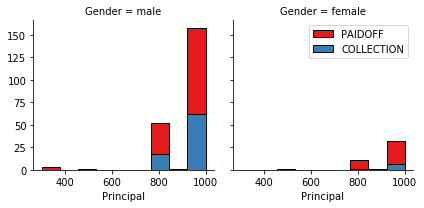

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

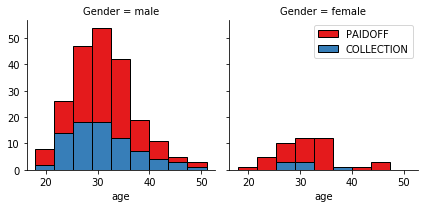

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

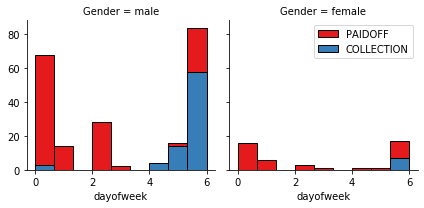

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan



Lets convert male to 0 and female to 1:

In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### we will now change the target vector y of loan status 

In [18]:
dfy = df[["loan_status"]]
dfy.head()

,loan_status
0,PAIDOFF
1,PAIDOFF
2,PAIDOFF
3,PAIDOFF
4,PAIDOFF


In [19]:
yvalues = pd.get_dummies(dfy['loan_status'])
yvalues.drop(['COLLECTION'], axis = 1,inplace=True)
yvalues.head()

,PAIDOFF
0,1
1,1
2,1
3,1
4,1


In [20]:
y = yvalues.values
y[0:5]

array([[1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [21]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Training Set 


### We shall use the following algorithms to train, choose the parameters/features, select best result on our training set after splitting to 90% training & 10% test:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression

# Algo 1: K Nearest Neighbor(kNN)
Let us find the best k to build the model with the best accuracy.  
- we select k by measuring accuracy on 90% training set & 10% test set for different values of K
- build the model with best k

In [22]:
# split the traininng data to find best k

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (311, 8) (311, 1)
Test set: (35, 8) (35, 1)


### lets check the accuracy range for different values of k

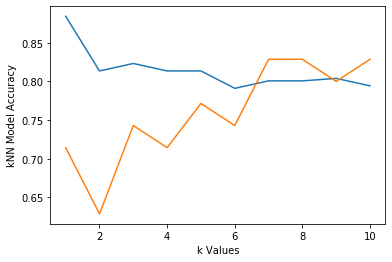

In [23]:

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier 


accuracy_train = []
accuracy_test = []
ks = range(1,11) # k values 1 to 10
for ak in ks:
    #Train Model and Predict 
    kNN_clf = KNeighborsClassifier(n_neighbors= ak)
    kNN_clf.fit(X_train, y_train)
    accuracy_train.append(kNN_clf.score(X_train, y_train)) # training accuracy
    accuracy_test.append(kNN_clf.score(X_test, y_test)) # testing accuracy
    
plt.plot(ks, accuracy_train, label="training accuracy")
plt.plot(ks, accuracy_test, label="testing accuracy")
plt.ylabel("kNN Model Accuracy")
plt.xlabel("k Values")
plt.show()

### from the above we choose the highest k from testing accuarcy as k = 5
## Now we build our kNN model

In [24]:
k = 5
# Train Model and Predict only on partail training now!
kNN_clf = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train.ravel())
kNN_clf

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [25]:
yhat = kNN_clf.predict(X_test)
print("kNN training accuracy: ", metrics.accuracy_score(y_train, kNN_clf.predict(X_train)))
print("kNN testing accuracy : ", metrics.accuracy_score(y_test, yhat))
print("kNN Jaccard Score    : ", metrics.jaccard_similarity_score(y_test, yhat))
print("kNN F1 Score         : ", metrics.f1_score(y_test, yhat))

kNN training accuracy:  0.8135048231511254
kNN testing accuracy :  0.7714285714285715
kNN Jaccard Score    :  0.7714285714285715
kNN F1 Score         :  0.8518518518518519


# Algo 2: Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree # it shows the default parameters

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [27]:
loanTree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [28]:
predTree = loanTree.predict(X_test)
print (predTree [0:5])

[0 1 1 1 1]


In [29]:
print("Decision Trees's training set accuracy     : ", metrics.accuracy_score(y_train, loanTree.predict(X_train)))
print("Decision Trees's testing (10%) set accuracy: ", metrics.accuracy_score(y_test, predTree))
print("Decision Trees's Jaccard Score             : ", metrics.jaccard_similarity_score(y_test, predTree))
print("Decision Trees's F1 Score                  : ", metrics.f1_score(y_test, predTree))

Decision Trees's training set accuracy     :  0.752411575562701
Decision Trees's testing (10%) set accuracy:  0.6857142857142857
Decision Trees's Jaccard Score             :  0.6857142857142857
Decision Trees's F1 Score                  :  0.8


In [30]:
# We will use the predTree later with test data for performance

# Algo 3: Support Vector Machine

In [31]:
from sklearn import svm

clf_rbf = svm.SVC(kernel='rbf')
clf_rbf.fit(X_train, y_train) 
yhat_rbf = clf_rbf.predict(X_test)
yhat_rbf [0:5]
print("SVM's Accuracy when Kernel is rbf: ", metrics.accuracy_score(y_test, yhat_rbf))

SVM's Accuracy when Kernel is rbf:  0.7714285714285715


In [32]:
clf_lin = svm.SVC(kernel='linear')
clf_lin.fit(X_train, y_train) 
yhat_lin = clf_lin.predict(X_test)
yhat_lin [0:5]
print("SVM's Accuracy when Kernel is linear: ", metrics.accuracy_score(y_test, yhat_lin))

SVM's Accuracy when Kernel is linear:  0.8571428571428571


In [33]:
clf_poly = svm.SVC(kernel='poly')
clf_poly.fit(X_train, y_train) 
yhat_poly = clf_poly.predict(X_test)
yhat_poly [0:5]
print("SVM's Accuracy when Kernel is poly: ", metrics.accuracy_score(y_test, yhat_poly))

SVM's Accuracy when Kernel is poly:  0.8


In [34]:
clf_sgm = svm.SVC(kernel='sigmoid')
clf_sgm.fit(X_train, y_train) 
yhat_sgm = clf_sgm.predict(X_test)
yhat_sgm [0:5]
print("SVM's Accuracy when Kernel is sigmoid: ", metrics.accuracy_score(y_test, yhat_sgm))

SVM's Accuracy when Kernel is sigmoid:  0.6857142857142857


# we will use linear kernel for SVM 

In [35]:
print("SVM training set accuracy     : ", metrics.accuracy_score(y_train, clf_lin.predict(X_train)))
print("SVM testing (10%) set accuracy: ", metrics.accuracy_score(y_test, yhat_lin))
print("SVM Jaccard Score             : ", metrics.jaccard_similarity_score(y_test, yhat_lin))
print("SVM F1 Score                  : ", metrics.f1_score(y_test, yhat_lin))

SVM training set accuracy     :  0.7395498392282959
SVM testing (10%) set accuracy:  0.8571428571428571
SVM Jaccard Score             :  0.8571428571428571
SVM F1 Score                  :  0.923076923076923


# Algo 4: Logistic Regression

In [36]:
import scipy.optimize as opt
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression().fit(X_train,y_train)
LogReg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
yhat_lr = LogReg.predict(X_test)
yhat_lr

array([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)

In [38]:
print("LogReg training set accuracy     : ", metrics.accuracy_score(y_train, LogReg.predict(X_train)))
print("LogReg testing (10%) set accuracy: ", metrics.accuracy_score(y_test, yhat_lr))
print("LogReg Jaccard Score             : ", metrics.jaccard_similarity_score(y_test, yhat_lr))
print("LogReg F1 Score                  : ", metrics.f1_score(y_test, yhat_lr))

LogReg training set accuracy     :  0.7395498392282959
LogReg testing (10%) set accuracy:  0.8
LogReg Jaccard Score             :  0.8
LogReg F1 Score                  :  0.8813559322033899


# Model Evaluation using Test set

In [39]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report, confusion_matrix
import itertools

First, download and load the test set:

In [40]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-05-13 11:26:07--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net|67.228.254.196|:443...connected.
HTTP request sent, awaiting response...200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2020-05-13 11:26:10 (99.2 MB/s) - ‘loan_test.csv’ saved [3642/3642]



In [41]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Load Test set for evaluation 

In [42]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [43]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
test_Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [44]:
test_df_tmp= test_df[["loan_status"]]
test_df_tmp.head()

,loan_status
0,PAIDOFF
1,PAIDOFF
2,PAIDOFF
3,PAIDOFF
4,PAIDOFF


In [45]:
tstY= pd.get_dummies(test_df_tmp['loan_status'])
tstY.drop(['COLLECTION'], axis = 1,inplace=True)
tstY.head()

,PAIDOFF
0,1
1,1
2,1
3,1
4,1


In [46]:
y_actual = tstY.values
y_actual[0:5]

array([[1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8)

In [47]:
X_testing = preprocessing.StandardScaler().fit(test_Feature).transform(test_Feature)
X_testing[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

# NOW WE GET OUR LAST STEP WHICH IS CHOOSING BEST MODEL BASED ON JACCARD & F1 SCORE

In [48]:
# first kNN
knn_pred = kNN_clf.predict(X_testing)
print("kNN jaccard_score: ", metrics.jaccard_similarity_score(y_actual, knn_pred))
print("kNN f1_score     : ", metrics.f1_score(y_actual, knn_pred))

kNN jaccard_score:  0.7037037037037037
kNN f1_score     :  0.8048780487804876


In [49]:
# 2nd lets predict with Decision Trees
test_predTree = loanTree.predict(X_testing)
print("Decision Trees jaccard_score: ", metrics.jaccard_similarity_score(y_actual, test_predTree))
print("Decision Trees f1_score     : ", metrics.f1_score(y_actual, test_predTree))

Decision Trees jaccard_score:  0.8148148148148148
Decision Trees f1_score     :  0.875


In [50]:
# 3rd lets predict with SVC
yhat_lint = clf_lin.predict(X_testing)
print("SVC's jaccard_score: ", metrics.jaccard_similarity_score(y_actual, yhat_lint))
print("SVC's f1_score     : ", metrics.f1_score(y_actual, yhat_lint))

SVC's jaccard_score:  0.7407407407407407
SVC's f1_score     :  0.851063829787234


In [51]:
# 4th lets predict with Logistic Regression
yhat_lr = LogReg.predict(X_testing)
yhat_lr

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)

In [52]:
yhat_lr_prob = LogReg.predict_proba(X_testing)
yhat_lr_prob[0:5]

array([[0.01209125, 0.98790875],
       [0.39785197, 0.60214803],
       [0.36512554, 0.63487446],
       [0.43382729, 0.56617271],
       [0.38725201, 0.61274799]])

In [53]:
print("Logistic Regression jaccard_score: ", metrics.jaccard_similarity_score(y_actual, yhat_lr))
print("Logistic Regression f1_score     : ", metrics.f1_score(y_actual, yhat_lr))
print("Logistic Regression logloss      : ", metrics.log_loss(y_actual, yhat_lr_prob))

Logistic Regression jaccard_score:  0.7592592592592593
Logistic Regression f1_score     :  0.8602150537634409
Logistic Regression logloss      :  0.47532381014082253


| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.70       | 0.80        |   NA      |
| Decision Tree      | 0.81       | 0.87        |   NA      |
| SVM                | 0.74       | 0.85        |   NA      |
| LogisticRegression | 0.76       | 0.86        | 0.47       |

# Final Conclusion: the decision tree algorithm was the best in accuracy with:
## Decision Trees Jaccard Score: 81%
## Decision Trees F1 Score     : 87%

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>